In [1]:
import re
import pandas as pd
import numpy as np

import util

# Lecture 18 – Text as Data

## DSC 80, Spring 2022

### Announcements

- Lab 6 is due **today at 11:59PM**.
    - **You don't have to do Question 3** ([even though it might work again](https://campuswire.com/c/G325FA25B/feed/1061)).
- Project 3 is due on **Thursday, May 12th at 11:59PM**.
- Look at the [Grade Report](https://www.gradescope.com/courses/379137/assignments/2051129/) on Gradescope, which summarizes your grades on all assessments so far.
    - Project 2 and Lab 5 grades have also been released.

### Agenda

- Example: Log parsing with regular expressions.
- Quantifying text data.
- Bag of words.

Remember to refer to [dsc80.com/resources/#regular-expressions](https://dsc80.com/resources/#regular-expressions).

## Example: Log parsing

Recall the **log string** from a few lectures ago.

In [3]:
s = '''132.249.20.188 - - [05/May/2022:14:26:15 -0800] "GET /my/home/ HTTP/1.1" 200 2585'''

Let's use our new regex syntax (including capturing groups) to extract the day, month, year, and time from the log string `s`.

In [4]:
exp = '\[(.+)\/(.+)\/(.+):(.+):(.+):(.+) .+\]'
re.findall(exp, s)

[('05', 'May', '2022', '14', '26', '15')]

While above regex works, it is not very **specific**. It _works_ on incorrectly formatted log strings.

In [5]:
other_s = '[adr/jduy/wffsdffs:r4s4:4wsgdfd:asdf 7]'
re.findall(exp, other_s)

[('adr', 'jduy', 'wffsdffs', 'r4s4', '4wsgdfd', 'asdf')]

### The more specific, the better!
* Be as specific in your pattern matching as possible – you don't want to match and extract strings that don't fit the pattern you care about.
    - `.*` matches every possible string, but we don't use it very often.
    
* A better date extraction regex:
```
\[(\d{2})\/([A-Z]{1}[a-z]{2})\/(\d{4}):(\d{2}):(\d{2}):(\d{2}) -\d{4}\]
```

    * `\d{2}` matches any 2-digit number.
    * `[A-Z]{1}` matches any single occurrence of any uppercase letter.
    * `[a-z]{2}` matches any 2 consecutive occurrences of lowercase letters.
    * Remember, special characters (`[`, `]`, `/`) need to be escaped with `\`.

In [ ]:
s

In [6]:
new_exp = '\[(\d{2})\/([A-Z]{1}[a-z]{2})\/(\d{4}):(\d{2}):(\d{2}):(\d{2}) -\d{4}\]'
re.findall(new_exp, s)

[('05', 'May', '2022', '14', '26', '15')]

A benefit of `new_exp` over `exp` is that it doesn't capture anything when the string doesn't follow the format we specified.

In [7]:
other_s

'[adr/jduy/wffsdffs:r4s4:4wsgdfd:asdf 7]'

In [8]:
re.findall(new_exp, other_s)

[]

### Another character class

The `\b` character class refers to "word boundaries". It matches anything that separates letters/digits/underscores.

In [9]:
re.findall('\\b\w+\\b', 'hello, my name is billy')

['hello', 'my', 'name', 'is', 'billy']

In [10]:
re.findall('\\b\w+\\b', 'hello-my-name-is-bil_ly!!')

['hello', 'my', 'name', 'is', 'bil_ly']

Remember, the `\w` character class refers to letters, digits, and underscores, i.e. "word" characters.

**Question:** What's with the `\\`?

### Aside: "raw" strings

- Regular expressions use `\` to escape special characters and to denote character classes (like `\w` and `\b`).
- Python uses `\` to demarcate special strings as well.

In [11]:
print('ho\ney')

ho
ey


Sometimes, the regex meaning and Python meaning of a special string clash.

In [12]:
'hi\billy'

'hi\x08illy'

In [14]:
print('hi\billy') # \b means "backspace" in Python

hiilly


In [13]:
print('hi\\billy')

hi\billy


To prevent Python from interpreting `\b`, `\n`, etc. as its own special strings, and to keep them in their "raw" form, use raw strings.

To create a raw string, add the character `r` right before the quotes.

In [15]:
r'hi\billy'

'hi\\billy'

In [16]:
print(r'hi\billy')

hi\billy


Raw strings can help us avoid misinterpretations like the one below.

In [17]:
re.findall('\b\w+\b', 'hello, my name is billy')

[]

In [18]:
re.findall(r'\b\w+\b', 'hello, my name is billy')

['hello', 'my', 'name', 'is', 'billy']

If you don't want to use a raw string, you'd instead have to escape the `\b` with another `\`, as we did on the previous slide:

In [ ]:
re.findall('\\b\w+\\b', 'hello, my name is billy')

## Reflection

### Limitations of regexes

Writing a regular expression is like writing a program.
* You need to know the syntax well.
* They can be easier to write than to read.
* They can be difficult to debug.

Regular expressions are terrible at certain types of problems. Examples:
* Anything involving counting (same number of instances of a and b).
* Anything involving complex structure (palindromes).
* Parsing highly complex text structure ([HTML](https://stackoverflow.com/questions/1732348/regex-match-open-tags-except-xhtml-self-contained-tags), for instance).

Below is a regular expression that validates email addresses in Perl. See [this article](http://www.ex-parrot.com/~pdw/Mail-RFC822-Address.html) for more details.



<center><img src="imgs/image_8.png" width=700></center>

StackOverflow crashed due to regex! See [this article](https://stackstatus.net/post/147710624694/outage-postmortem-july-20-2016) for the details.

<center><img src='imgs/so_regex.png' width=60%></center>

### Advice

- You don't need to force yourself to "memorize" regex syntax – refer to the resources in the [Agenda](#Agenda) section of the lecture and on the [Resources](https://dsc80.com/resources#regular-expressions) tab of the course website.
- Also refer to the three tables of syntax in the lecture:
    - [Regex building blocks](#Regex-building-blocks-🧱).
    - [More regex syntax](#More-regex-syntax).
    - [Even more regex syntax](#Even-more-regex-syntax).
- **Note:** You don't always have to use regular expressions! If Python/`pandas` string methods work for your task, you can still use those.
- **Play [Regex Golf](https://alf.nu/RegexGolf?world=regex&level=r00) to practice!** 🏌️



## Quantifying text data

### Quantifying text data

- How do we **quantify** the similarity of two text documents?
- How do we use a text document as input in a regression or classification model?
- **How do we turn a text document into a vector of numbers?**
    - From 40A: A **design matrix** consists of one row per "data point", and one column per "feature".


### Example: San Diego employee salaries

Recall, in Lectures 1 and 2, we worked with a dataset of San Diego city employee salaries in 2020.

In [19]:
# 2021 data is now actually available, but we will use 2020 data as we did earlier in the quarter
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2020.csv')
util.anonymize_names(salaries)

In [20]:
salaries.head()

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
0,Michael Xxxx,Police Officer,117691.0,187290.0,13331.00,36380.0,318312.0,NaN,354692.0,2020,NaN,San Diego,FT
1,Gary Xxxx,Police Officer,117691.0,160062.0,42946.00,31795.0,320699.0,NaN,352494.0,2020,NaN,San Diego,FT
2,Eric Xxxx,Fire Engineer,35698.0,204462.0,69121.00,38362.0,309281.0,NaN,347643.0,2020,NaN,San Diego,PT
3,Gregg Xxxx,Retirement Administrator,305000.0,0.0,12814.00,24792.0,317814.0,NaN,342606.0,2020,NaN,San Diego,FT
4,Joseph Xxxx,Fire Battalion Chief,94451.0,157778.0,48151.00,42096.0,300380.0,NaN,342476.0,2020,NaN,San Diego,FT


We asked the question, "Does gender influence pay?"

A followup question to that was "Do men and women make similar salaries amongst those with similar jobs?" – but what makes two jobs similar?

### Exploring job titles

In [21]:
jobtitles = salaries['Job Title']
jobtitles.head()

0              Police Officer
1              Police Officer
2               Fire Engineer
3    Retirement Administrator
4        Fire Battalion Chief
Name: Job Title, dtype: object

How many job titles are there in the dataset? How many **unique** job titles are there?

In [22]:
jobtitles.shape[0], jobtitles.nunique()

(12605, 647)

What are the most common job titles?

In [23]:
jobtitles.value_counts().iloc[:100]

Police Officer           2129
Fire Fighter 2            325
Asst Eng-Civil            279
Grounds Maint Wrkr 2      278
Rec Leader 1              260
                         ... 
Librarian 4                25
Asst Fleet Technician      25
Public Works Supv          25
Custodian 2                25
Asst Deputy Director       25
Name: Job Title, Length: 100, dtype: int64

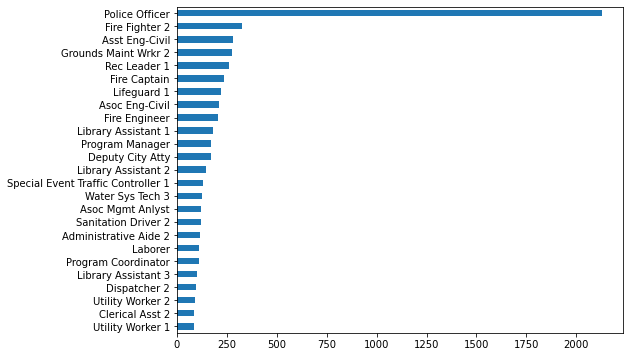

In [24]:
jobtitles.value_counts().iloc[:25].sort_values().plot(kind='barh', figsize=(8, 6));

### Messiness of job titles

- Are there multiple representations of the same job title (e.g. `'Assistant Fire Chief'` vs. `'Asst. Fire Chief'`?
- Are there multiple representations of the same word that is used in multiple job titles (e.g. `'Civil Eng.'` vs `'Mechanical engineer'`)?

Run the cell below repeatedly to get a feel for the "messiness" of job titles in their current state.

In [28]:
jobtitles.sample(10)

12085                          Pool Guard 1
428                          Police Officer
11560                          Rec Leader 1
7827                           Plant Tech 2
11394    Special Event Traffic Controller 1
10330                        Police Officer
6361                  Zoning Investigator 2
1748                    Sr Traffic Engineer
4934          Plant Procs Cntrl Electrician
10973                          Pool Guard 1
Name: Job Title, dtype: object

### Canonicalizing job titles

Let's try to **canonicalize** job titles. To do this, we'll look at:

- Punctuation.
- "Glue" words.
- Abbreviations.

### Punctuation

Are there job titles with unnecessary punctuation that we can remove? 

- To find out, we can write a regular expression that looks for characters other than letters, numbers, and spaces.

- We can use regular expressions with the `.str` methods we learned earlier in the quarter just by using `regex=True`.

In [29]:
jobtitles.str.contains(r'[^A-Za-z0-9 ]', regex=True).sum()

1133

In [30]:
jobtitles[jobtitles.str.contains(r'[^A-Za-z0-9 ]', regex=True)].head()

67              Fire Captain-Mast
189    Park & Recreation Director
217      Deputy City Atty - Unrep
261             Fire Captain-Mast
283      Deputy City Atty - Unrep
Name: Job Title, dtype: object

It seems like we should replace these pieces of punctuation with a single space.

### "Glue" words

Are there job titles with "glue" words in the middle, such as Assistant <u>to the</u> Chief?

To figure out if any titles contain the word `'to'`, we **can't** just do the following, because it will evaluate to `True` for job titles that have `'to'` anywhere in them, even if not as a standalone word.

In [31]:
# Why are we converting to lowercase?
jobtitles.str.lower().str.contains('to').sum()

833

In [32]:
jobtitles[jobtitles.str.lower().str.contains('to')]

3             Retirement Administrator
22                 Department Director
31       Asst Retirement Administrator
55                  Asst City Attorney
62                 Department Director
                     ...              
12484                    Storekeeper 1
12502            Storm Water Inspctr 3
12504                 Equip Operator 2
12532         Supv Storm Water Inspctr
12552             Sr Customer Srvs Rep
Name: Job Title, Length: 833, dtype: object

Instead, we need to look for `'to'` separated by word boundaries.

In [33]:
jobtitles.str.lower().str.contains(r'\bto\b', regex=True).sum()

11

In [34]:
jobtitles[jobtitles.str.lower().str.contains(r'\bto\b', regex=True)]

723            Principal Asst To City Atty
738                 Asst To The Fire Chief
2087                  Asst To The Director
5221     Conf Secretary To Chief Oper Ofcr
5884                  Asst To The Director
5945        Conf Secretary To Police Chief
6454           Conf Secretary To City Atty
11481              Conf Secretary To Mayor
12061                 Asst To The Director
12120          Conf Secretary To City Atty
12207              Conf Secretary To Mayor
Name: Job Title, dtype: object

We can look for other filler words too, like `'the'` and `'for'`.

In [35]:
jobtitles[jobtitles.str.lower().str.contains(r'\bthe\b', regex=True)]

738      Asst To The Fire Chief
2087       Asst To The Director
5884       Asst To The Director
12061      Asst To The Director
Name: Job Title, dtype: object

In [36]:
jobtitles[jobtitles.str.lower().str.contains(r'\bfor\b', regex=True)]

3352    Asst For Community Outreach
6356    Asst For Community Outreach
Name: Job Title, dtype: object

We should probably remove these "glue" words.

### Fixing punctuation and removing "glue" words

To canonicalize job titles, we'll start by:
- converting to lowercase,
- removing each occurrence of `'to'`, `'the'`, and `'for'`,
- replacing each non-letter/digit/space character with a space, and
- replacing each sequence of multiple spaces with a single space.

In [37]:
jobtitles = (
    jobtitles
    .str.lower()
    .str.replace(r'\bto|\bthe|\bfor', '', regex=True)
    .str.replace('[^A-Za-z0-9 ]', ' ', regex=True)
    .str.replace(' +', ' ', regex=True)               # ' +' matches 1 or more occurrences of a space
    .str.strip()                                      # Removes leading/trailing spaces if present
)

In [38]:
jobtitles.sample(10)

5494                    master fleet technician
5580                        program coordinator
10642                               lifeguard 1
9566                        library assistant 2
8578                        deputy city clerk 1
7396                      administrative aide 1
5271     info sys anlyst 4 supv cntrl sys prgmr
6431                               accountant 2
11870                     administrative aide 1
5946                               asst chemist
Name: Job Title, dtype: object

### Abbreviations 

Which job titles are inconsistently described? Let's look at three categories – librarians, engineers, and directors.

In [39]:
jobtitles[jobtitles.str.contains('libr')].value_counts()

library assistant 1      179
library assistant 2      143
library assistant 3      101
librarian 2               66
librarian 3               32
librarian 4               25
supv librarian             7
library technician         7
librarian 1                6
deputy library dir         2
city librarian             1
librarian 3 law librn      1
sr library tech            1
Name: Job Title, dtype: int64

In [40]:
jobtitles[jobtitles.str.contains('eng')].value_counts()

asst eng civil                             279
asoc eng civil                             210
fire engineer                              208
sr civil engineer                           71
jr engineer civil                           70
principal engrng aide                       60
asst eng traffic                            33
asoc eng traffic                            28
structural engrng asoc                      23
student engineer                            20
sr engineering aide                         16
sr traffic engineer                         13
asoc eng electrical                         13
auto messenger 1                             9
structural engrng sr                         9
asst eng civil cntrct spec                   9
asoc eng civil sr cntrct spec                9
auto messenger 2                             8
asst eng electrical                          7
asoc eng fire protection                     5
asoc eng mechanical                          5
asoc commctns

In [41]:
jobtitles[jobtitles.str.contains('dir')].value_counts()

deputy director                    78
asst rec ctr dir                   45
rec cntr dir 3                     30
asst deputy director               25
department director                20
rec cntr dir 2                     14
asst department director           10
executive director                  9
rec cntr dir 1                      9
asst development services dir       3
asst director                       3
deputy library dir                  2
real estate assets dir              2
governmental rel dir                2
deputy pers director                2
risk management director            1
development services dir            1
deputy planning director            1
asst environmental services dir     1
personnel director                  1
planning director                   1
asst planning director              1
environmental services dir          1
asst metro wstwtr dir               1
public utilities director           1
park recreation director            1
asst pers di

### The limits of canonicalization

- Our current approach requires a lot of manual labor.
    - There may be more abbreviations in use amongst job titles (like `'asst'` for `'assistant'`), but how do we find them?
- Remember, our goal is to quantify how similar two job titles are.
- **Idea:** Two job titles are similar if they contain similar words (regardless of order).

## Bag of words 👜

### A counts matrix

Let's create a "counts" matrix, such that:
- there is 1 row per job title,
- there is 1 column per **unique** word that is used in job titles, and
- the value in row `title` and column `word` is the number of occurrences of `word` in `title`.

Such a matrix might look like:

| | senior | lecturer | teaching | professor | assistant | associate |
| --- | --- | --- | --- | --- | --- | --- |
| **senior lecturer** | 1 | 1 | 0 | 0 | 0 | 0 |
| **assistant teaching professor** | 0 | 0 | 1 | 1 | 1 | 0 | 
| **associate professor** | 0 | 0 | 0 | 1 | 0 | 1 |
| **senior assistant to the assistant professor** | 1 | 0 | 0 | 1 | 2 | 0 |

### Creating a counts matrix

First, we need to determine all words that are used across all job titles.

In [42]:
jobtitles.str.split()

0                  [police, officer]
1                  [police, officer]
2                   [fire, engineer]
3        [retirement, administrator]
4           [fire, battalion, chief]
                    ...             
12600             [asst, eng, civil]
12601              [police, officer]
12602                [asst, planner]
12603             [project, ofcr, 1]
12604           [utility, worker, 2]
Name: Job Title, Length: 12605, dtype: object

In [43]:
all_words = jobtitles.str.split().sum()
all_words[:10]

['police',
 'officer',
 'police',
 'officer',
 'fire',
 'engineer',
 'retirement',
 'administrator',
 'fire',
 'battalion']

Next, we need to find a list of all **unique** words used in titles. (We can do this with `np.unique`, but `value_counts` shows us the distribution, which is interesting.)

In [44]:
unique_words = pd.Series(all_words).value_counts()
unique_words.head(10)

2          2438
police     2329
officer    2150
1          1589
fire       1067
asst        721
civil       656
eng         615
3           612
asoc        563
dtype: int64

In [45]:
len(unique_words)

435

For each of the 435 unique words that are used in job titles, we can count the number of occurrences of the word in each job title.
- `'assistant fire chief'` contains the word `'assistant'` once, the word `'fire'` once, and the word `'chief'` once.
- `'assistant managers assistant'` contains the word `'assistant'` twice and the word `'managers'` once.

In [46]:
# Created using a dictionary to avoid a "DataFrame is highly fragmented" warning.
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = jobtitles.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict)

In [47]:
counts_df.head()

,2,police,officer,1,fire,asst,civil,eng,3,asoc,...,motive,metro,sign,stores,sec,law,librn,risk,medical,african
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`counts_df` has one row for all 12605 job titles (employees), and one column for each unique word that is used in a job title.

In [48]:
counts_df.shape

(12605, 435)

To put into context what the numbers in `counts_df` mean, we can show the actual job title for each row.

In [49]:
counts_df = pd.concat([jobtitles.to_frame(), counts_df], axis=1).set_index('Job Title')
counts_df.head()

,2,police,officer,1,fire,asst,civil,eng,3,asoc,...,motive,metro,sign,stores,sec,law,librn,risk,medical,african
Job Title,,,,,,,,,,,,,,,,,,,,,
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire engineer,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retirement administrator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire battalion chief,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first row tells us that the first job title contains `'police'` once and `'officer'` once. The fifth row tells us that the fifth job title contains `'fire'` once.

### Interpreting the counts matrix

In [50]:
counts_df.head()

,2,police,officer,1,fire,asst,civil,eng,3,asoc,...,motive,metro,sign,stores,sec,law,librn,risk,medical,african
Job Title,,,,,,,,,,,,,,,,,,,,,
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire engineer,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retirement administrator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire battalion chief,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The Series below describes the 20 most common words used in job titles, along with the number of times they appeared in all job titles (including repeats). We will call these words "top 20".

In [51]:
counts_df.iloc[:, :20].sum()

2            2438
police       2329
officer      2150
1            1589
fire         1067
asst          721
civil         656
eng           615
3             612
asoc          563
assistant     535
sr            529
supv          501
anlyst        477
tech          454
fighter       449
rec           444
library       433
maint         430
engineer      402
dtype: int64

The Series below describes the **number of top 20 words** used in each job title.

In [52]:
counts_df.iloc[:, :20].sum(axis=1)

Job Title
police officer              2
police officer              2
fire engineer               2
retirement administrator    0
fire battalion chief        1
                           ..
asst eng civil              3
police officer              2
asst planner                1
project ofcr 1              1
utility worker 2            1
Length: 12605, dtype: int64

### Question: What job titles are most similar to `'asst fire chief'`?

- Remember, our idea was to treat two job titles as similar if they contain similar words (regardless of order).
- Now that we have `counts_df`, we have a (row) vector for each job title.
- **How do we measure how similar two vectors are?**

To start, let's compare `'asst fire chief'` to `'fire battalion chief'`.

In [53]:
afc = counts_df.loc['asst fire chief'].iloc[0]
afc

2          0
police     0
officer    0
1          0
fire       1
          ..
law        0
librn      0
risk       0
medical    0
african    0
Name: asst fire chief, Length: 435, dtype: int64

In [54]:
fbc = counts_df.loc['fire battalion chief'].iloc[0]
fbc

2          0
police     0
officer    0
1          0
fire       1
          ..
law        0
librn      0
risk       0
medical    0
african    0
Name: fire battalion chief, Length: 435, dtype: int64

We can stack these two vectors horizontally.

In [55]:
pair_counts = (
    pd.concat([afc, fbc], axis=1)
    .sort_values(by=['asst fire chief', 'fire battalion chief'], ascending=False)
    .head(10)
    .T
)

pair_counts

,fire,chief,asst,battalion,2,police,officer,1,civil,eng
asst fire chief,1,1,1,0,0,0,0,0,0,0
fire battalion chief,1,1,0,1,0,0,0,0,0,0


One way to measure how similar the above two vectors are is through their **dot product**.

In [56]:
np.sum(pair_counts.iloc[0] * pair_counts.iloc[1])

2

Here, since both vectors consist only of 1s and 0s, the dot product is equal to the **number of shared words** between the two job titles.

### Aside: dot product

- Recall, if $\vec{a} = \begin{bmatrix} a_1 & a_2 & ... & a_n \end{bmatrix}^T$ and $\vec{b} = \begin{bmatrix} b_1 & b_2 & ... & b_n \end{bmatrix}^T$ are two vectors, then their **dot product** $\vec{a} \cdot \vec{b}$ is defined as:

$$\vec{a} \cdot \vec{b} = a_1b_1 + a_2b_2 + ... + a_nb_n$$

- The dot product also has a **geometric** interpretation. If $|\vec{a}|$ and $|\vec{b}|$ are the $L_2$ norms (lengths) of $\vec{a}$ and $\vec{b}$, and $\theta$ is the angle between $\vec{a}$ and $\vec{b}$, then:

$$\vec{a} \cdot \vec{b} = |\vec{a}| |\vec{b}| \cos \theta$$

- $\cos \theta$ is equal to its maximum value (1) when $\theta = 0$, i.e. when $\vec{a}$ and $\vec{b}$ point in the same direction. 

- 🚨 **Key idea: The more similar two vectors are, the larger their dot product is!**

### Computing similarities

To find the job title that is most similar to `'asst fire chief'`, we can compute the dot product of the `'asst fire chief'` word vector with all other titles' word vectors, and find the title with the highest dot product.

In [57]:
counts_df.head()

,2,police,officer,1,fire,asst,civil,eng,3,asoc,...,motive,metro,sign,stores,sec,law,librn,risk,medical,african
Job Title,,,,,,,,,,,,,,,,,,,,,
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
police officer,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire engineer,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retirement administrator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fire battalion chief,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
afc

2          0
police     0
officer    0
1          0
fire       1
          ..
law        0
librn      0
risk       0
medical    0
african    0
Name: asst fire chief, Length: 435, dtype: int64

To do so, we can apply `np.dot` to each row that doesn't correspond to `'asst fire chief'`.

In [59]:
dots = (
    counts_df[counts_df.index != 'asst fire chief']
    .apply(lambda s: np.dot(s, afc), axis=1)
    .sort_values(ascending=False)
)

dots

Job Title
asst deputy chief oper ofcr    2
fire battalion chief           2
deputy fire chief              2
fire battalion chief           2
deputy fire chief              2
                              ..
lifeguard 3                    0
water sys tech 3               0
sr commctns tech               0
sr life safety inspector       0
utility worker 2               0
Length: 12601, dtype: int64

The unique job titles that are **most similar** to `'asst fire chief'` are given below.

In [60]:
np.unique(dots.index[dots == dots.max()])

array(['asst chief oper ofcr', 'asst deputy chief oper ofcr',
       'asst fire marshal civ', 'deputy fire chief',
       'fire battalion chief', 'fire chief'], dtype=object)

Note that they all share two words in common with `'asst fire chief'`.

**Note:** To truly use the dot product as a measure of similarity, we should **normalize** by the lengths of the word vectors. More on this soon.

### Bag of words

- The **bag of words** model represents texts (e.g. job titles, sentences, documents) as **vectors of word counts**.
    - The "counts" matrices we have worked with so far were created using the bag of words model.
    - The bag of words model defines a **vector space** in $\mathbb{R}^{\text{number of unique words}}$.
- It is called "bag of words" because it doesn't consider **order**.

<center><img src='imgs/bag-of-words.jpeg' width=45%></center>

<center><a href="https://42f6861cgkip12ijm63i3orf-wpengine.netdna-ssl.com/wp-content/uploads/2020/12/2020-07-bagofwords.jpg">(source)</a></center>

### Cosine similarity and bag of words

To measure the similarity between two word vectors, we compute their dot product, also known as their **cosine similarity**.

$$\cos \theta = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}| | \vec{b}|}$$

If $\cos \theta$ is large, the two word vectors are similar. **It is important to normalize by the lengths of the vectors**, otherwise texts with more words will have artificially high similarities with other texts.

**Note:** Sometimes, you will see the **cosine distance** being used. It is the complement of cosine similarity:
  
  $$\text{dist}(\vec{a}, \vec{b}) = 1 - \cos \theta$$
  
If $\text{dist}(\vec{a}, \vec{b})$ is small, the two word vectors are similar.

### A recipe for computing similarities

Given a set of texts, to find the **most similar** text to one text $T$ in particular:
- Use the bag of words model to create a counts matrix. Specifically:
    - Create an index out of **all** distinct words used across all texts.
    - Create a single vector for each text by counting the number of occurrences of each distinct word.
- Compute the cosine similarity between text $T$ and all other texts.
- The other text with the greatest cosine similarity is the most similar, under the bag of words model.

### Example: Global warming 🌎

Consider the following **sentences**.

In [69]:
sentences = pd.Series([
    'I really want global peace',
    'I must love love global warming',
    'We must solve climate change'
])

sentences

0         I really want global peace
1    I must love love global warming
2       We must solve climate change
dtype: object

Let's represent each sentence using the bag of words model.

In [70]:
unique_words = pd.Series(sentences.str.split().sum()).value_counts()
unique_words

I          2
global     2
must       2
love       2
really     1
want       1
peace      1
warming    1
We         1
solve      1
climate    1
change     1
dtype: int64

In [71]:
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = sentences.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(sentences)

In [72]:
counts_df

,I,global,must,love,really,want,peace,warming,We,solve,climate,change
I really want global peace,1,1,0,0,1,1,1,0,0,0,0,0
I must love love global warming,1,1,1,2,0,0,0,1,0,0,0,0
We must solve climate change,0,0,1,0,0,0,0,0,1,1,1,1


Let's now find the cosine similarity between each sentence.

In [73]:
# There is an easier way of doing this in sklearn, as we will see soon
def sim_pair(s1, s2):
    return np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))

In [74]:
sim_pair(counts_df.iloc[0], counts_df.iloc[1])

0.31622776601683794

In [75]:
sim_pair(counts_df.iloc[0], counts_df.iloc[2])

0.0

In [76]:
sim_pair(counts_df.iloc[1], counts_df.iloc[2])

0.15811388300841897

**Issue:** Bag of words only encodes the **words** that each sentence uses, not their **meanings**.
- Sentence 0 and sentence 2 have similar meanings, but have no shared words.
- Sentence 0 and sentence 1 have very different meanings, but a relatively high cosine similarity.

### Pitfalls of the bag of words model

Remember, the key assumption underlying the bag of words model is that **two texts are similar if they share many words in common**.

- The bag of words model doesn't consider **order**.
    - The job titles `'asst fire chief'` and `'chief fire asst'` are treated as the same.
- The bag of words model treats all words as being equally important.
    - `'asst'` and `'fire'` have the same importance, even though `'fire'` is probably more important in describing someone's job title.
- The bag of words model doesn't consider the **meaning** of words.
    - `'I love data science'` and `'I hate data science'` share 75% of their words, but have very different meanings.

## Summary, next time

### Summary

- `pandas` `.str` methods can use regular expressions; just set `regex=True`.
- Canonicalization can be difficult in practice when working with large datasets.
- The bag of words model allows us to turn texts into numerical vectors of word counts.
    - It treats two texts as similar if they share many words in common.
    - It doesn't consider the order, importance, or meaning of words.
- **Next time:** An improvement to bag of words.